In [15]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt


# Custom transformer for splitting 'Cabin' feature
class CabinSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cabin_df = X['Cabin'].fillna('Unknown/0/Unknown').str.split('/', expand=True)
        cabin_df.columns = ['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']
        return cabin_df

#preprocessing pipelines
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cabin_feature = ['Cabin'] 

# Num pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Cabin pipeline
cabin_transformer = Pipeline(steps=[
    ('cabin_split', CabinSplitter()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cabin', cabin_transformer, cabin_feature)
    ])

In [16]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP']),
                                ('cabin',
                                 Pipeline(steps=[('cabin_split',
                                                  CabinSplitter()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Cabin'])])

In [17]:
import pandas as pd
data = pd.read_csv('data/space.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
2,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
3,0010_01,Earth,False,G/1/S,TRAPPIST-1e,48.0,False,719.0,1.0,65.0,0.0,24.0,Reney Baketton,False
4,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False


In [19]:
from sklearn.model_selection import train_test_split

target = 'Transported'
X = data.drop(columns=[target, 'Name', 'PassengerId'])
y = data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [23]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])
lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP']),
                                                 ('cabin',
                                                  Pipeline(steps=[('cabin_split',
                                                                   CabinSplitter()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [25]:
from sklearn.metrics import recall_score, precision_score
#checking how the first model performs
lr_pipeline.fit(X_train, y_train)
y_predicted = lr_pipeline.predict(X_train)

print(f"Recall =  {recall_score(y_train, y_predicted)}")
print(f"Precision = {precision_score(y_train, y_predicted)}")

Recall =  0.8500327439423707
Precision = 0.836340206185567


In [24]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
    ])
knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP']),
                                                 ('cabin',
                                                  Pipeline(steps=[('cabin_split',
                                                                   CabinSplitter()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin'])])),
                ('classifier', KNeighborsClassifier())])

In [26]:
from sklearn.metrics import recall_score, precision_score
knn_pipeline.fit(X_train, y_train)
y_predicted = knn_pipeline.predict(X_train)

print(f"Recall = {recall_score(y_train, y_predicted)}")
print(f" Precin = {precision_score(y_train, y_predicted)}")


Recall = 0.8379174852652259
 Precin = 0.8434410019775873


In [29]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
lr_params = {
    'classifier__C': [0.1, 1, 10],  
    'classifier__solver': ['liblinear', 'lbfgs']  
}

# Setup RandomizedSearchCV
lr_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_params,
    cv=5,
    scoring='roc_auc', 
    random_state=42
)

# Fit the model
lr_search.fit(X_train, y_train)


/home/oce23/downloads/condainit/envs/dsml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_...),
                                                                               ['HomePlanet',
                                                                                'CryoSleep',
                                                                                'Destination',
                                                                                'VIP']),
                                                                              ('cabin',
                                                                               Pipeline(steps=[('cabin_split',
                                                                                                CabinSplitter()),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Cabin'])])),
                                             ('classifier',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'classifier__C': [0.1, 1, 10],
                                        'classifier__solver': ['liblinear',
                                                               'lbfgs']},
                   random_state=42, scoring='roc_auc')

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid for KNN
knn_params = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Setup RandomizedSearchCV for KNN
knn_search = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=knn_params,
    cv=5,
    scoring='roc_auc',
    random_state=42
)

# Fit KNN hyperparameter search
knn_search.fit(X_train, y_train)

# Best parameters for KNN
print("Best KNN Parameters: ", knn_search.best_params_)


Best KNN Parameters:  {'classifier__weights': 'uniform', 'classifier__n_neighbors': 11}


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Logistic Regression Evaluation
best_lr = lr_search.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Metrics:")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))
print("Recall: ", recall_score(y_test, y_pred_lr))
print("F1 Score: ", f1_score(y_test, y_pred_lr))
print("AUC-ROC: ", roc_auc_score(y_test, y_prob_lr))

# KNN Evaluation
best_knn = knn_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]

print("\nKNN Metrics:")
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 Score: ", f1_score(y_test, y_pred_knn))
print("AUC-ROC: ", roc_auc_score(y_test, y_prob_knn))


Logistic Regression Metrics:
Accuracy:  0.799079754601227
Precision:  0.791970802919708
Recall:  0.8194864048338368
F1 Score:  0.8054936896807721
AUC-ROC:  0.8807593575589876

KNN Metrics:
Accuracy:  0.7883435582822086
Precision:  0.7987616099071208
Recall:  0.7794561933534743
F1 Score:  0.7889908256880734
AUC-ROC:  0.8751858806034767


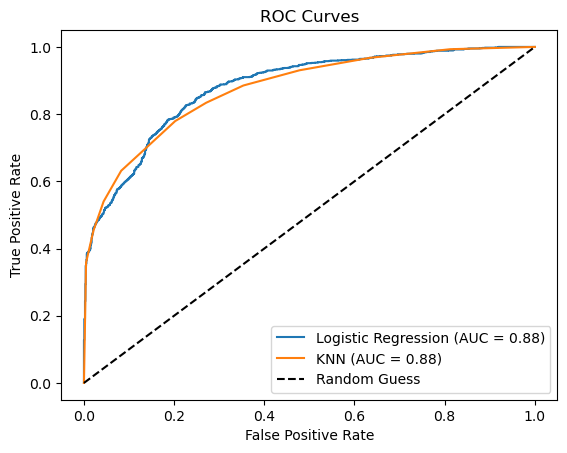

In [32]:
# Logistic Regression ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_lr)))

# KNN ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_knn)))

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


Model Selection and Comparison
I evaluated two models: Logistic Regression and K-Nearest Neighbors (KNN). These models were compared using multiple performance metrics, including Accuracy, Precision, Recall, F1 Score, and AUC-ROC. 

Logistic Regression outperformed KNN slightly by achieving a higher AUC-ROC score (0.88 vs. 0.875) and better Precision, Recall, and F1 scores.